<a href="https://colab.research.google.com/github/githshine/Facial-Expression-Recognition/blob/main/Main_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub
shuvoalok_raf_db_dataset_path = kagglehub.dataset_download('shuvoalok/raf-db-dataset')

print('Data source import complete.')


100%|██████████| 37.7M/37.7M [00:00<00:00, 184MB/s]

Extracting files...


Data source import complete.


Preprocessing

In [ ]:
import os
import cv2
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm.notebook import tqdm

from sklearn.utils import shuffle
from sklearn.metrics import classification_report, accuracy_score, RocCurveDisplay, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer,LabelEncoder, label_binarize
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.svm import LinearSVC

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential, save_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.applications import DenseNet121
from sklearn.metrics import roc_curve, auc

from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

from keras.backend import clear_session
import gc
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image


In [ ]:
import os

dataset_path = shuvoalok_raf_db_dataset_path  # Path from KaggleHub
print("Dataset files:", os.listdir(dataset_path))


Dataset files: ['test_labels.csv', 'DATASET', 'train_labels.csv']


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# Define the correct paths
train_labels_path = os.path.join(shuvoalok_raf_db_dataset_path, "train_labels.csv")
test_labels_path = os.path.join(shuvoalok_raf_db_dataset_path, "test_labels.csv")

# Check if the files exist
if os.path.exists(train_labels_path) and os.path.exists(test_labels_path):
    train_labels = pd.read_csv(train_labels_path)
    test_labels = pd.read_csv(test_labels_path)
    print("Train labels:")
    print(train_labels.head())

    classes = ['surprise', 'fear', 'disgust', 'happy', 'sad', 'angry', 'neutral']

    label_map = {label: (idx+1) for idx, label in enumerate(classes)}

    print(label_map)
else:
    print("Error: Label files not foun....")


Train labels:
                     image  label
0  train_00001_aligned.jpg      5
1  train_00002_aligned.jpg      5
2  train_00003_aligned.jpg      4
3  train_00004_aligned.jpg      4
4  train_00005_aligned.jpg      5
{'surprise': 1, 'fear': 2, 'disgust': 3, 'happy': 4, 'sad': 5, 'angry': 6, 'neutral': 7}


In [ ]:
import os
import cv2
import numpy as np
from tqdm.notebook import tqdm

# Define dataset paths
dataset_dir = os.path.join(shuvoalok_raf_db_dataset_path, "DATASET")
train_dir = os.path.join(dataset_dir, "train")
test_dir = os.path.join(dataset_dir, "test")

# Function to load images and labels from the directory
def load_data(dataset_dir, label_map):
    images = []
    labels = []

    if not os.path.exists(dataset_dir):
        print(f"Error: The directory {dataset_dir} does not exist.")
        return np.array([]), np.array([])

    for label, idx in tqdm(label_map.items()):
        folder_path = os.path.join(dataset_dir, str(idx))
        if not os.path.exists(folder_path):
            print(f"Warning: The folder {folder_path} does not exist. Skipping...")
            continue

        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            if img is None:
                print(f"Warning: Could not read image {img_path}. Skipping...")
                continue

            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img_rgb)
            labels.append(idx)

    return np.array(images), np.array(labels)

# Load train and test datasets
train_images, train_labels = load_data(train_dir, label_map)
test_images, test_labels = load_data(test_dir, label_map)

# Print dataset shapes
print(f"Train images shape: {train_images.shape}")
print(f"Test images shape: {test_images.shape}")


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Train images shape: (12271, 100, 100, 3)
Test images shape: (3068, 100, 100, 3)


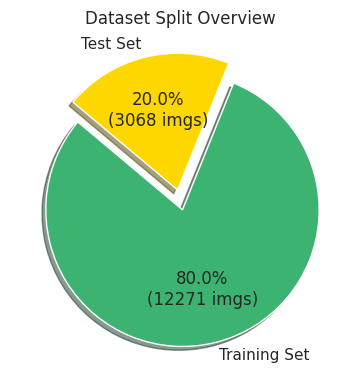

In [ ]:
import matplotlib.pyplot as plt

# Compute total image count
total_images = len(train_images) + len(test_images)

# Determine percentage allocation
train_percentage = (len(train_images) / total_images) * 100
test_percentage = (len(test_images) / total_images) * 100

# Pie chart configuration
labels = ['Training Set', 'Test Set']
sizes = [train_percentage, test_percentage]
colors = ['mediumseagreen', 'gold']
explode = (0.05, 0.1)

# Generate the pie chart
plt.figure(figsize=(4, 4))
plt.pie(
    sizes,
    labels=labels,
    explode=explode,
    autopct=lambda p: f'{p:.1f}%\n({int(p * total_images / 100)} imgs)',
    startangle=140,
    colors=colors,
    shadow=True
)
plt.title('Dataset Split Overview')
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.show()


Train label counts: Counter({np.int64(4): 4772, np.int64(7): 2524, np.int64(5): 1982, np.int64(1): 1290, np.int64(3): 717, np.int64(6): 705, np.int64(2): 281})
Test counts: [329, 74, 160, 1185, 478, 162, 680]


<ipython-input-27-1ba0231f7c26>:62: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


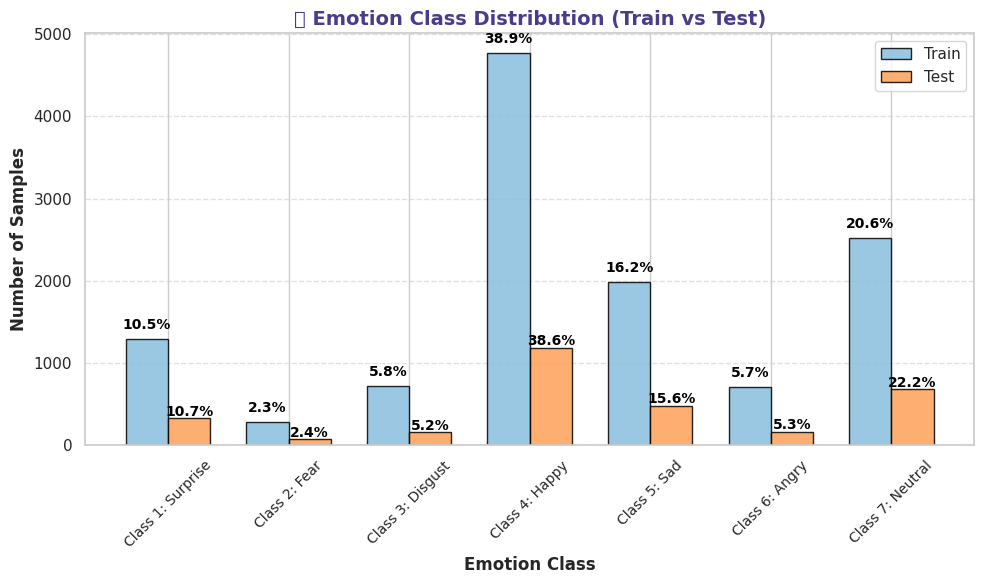

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

# Count occurrences of each class in train and test datasets
train_label_counts = Counter(train_labels)
test_label_counts = Counter(test_labels)

print('Train label counts:', train_label_counts)

train_classes = sorted(train_label_counts.keys())
train_counts = [train_label_counts[cls] for cls in train_classes]

test_classes = sorted(test_label_counts.keys())
test_counts = [test_label_counts[cls] for cls in test_classes]

print('Test counts:', test_counts)

# Compute total samples in train and test sets
total_train = sum(train_counts)
total_test = sum(test_counts)

train_percentages = [(count / total_train) * 100 for count in train_counts]
test_percentages = [(count / total_test) * 100 for count in test_counts]

train_color = sns.color_palette("Blues")[2]  # Light blue
test_color = sns.color_palette("Oranges")[2]  # Light orange


emotion_classes = ["Surprise", "Fear", "Disgust", "Happy", "Sad", "Angry", "Neutral"]

plt.figure(figsize=(10, 6))
x_positions = range(len(train_classes))
bar_width = 0.35

# Train bars
plt.bar(x_positions, train_counts, width=bar_width, label="Train", alpha=0.85,
        color=train_color, edgecolor='black')

# Test bars
plt.bar([pos + bar_width for pos in x_positions], test_counts, width=bar_width, label="Test", alpha=0.85,
        color=test_color, edgecolor='black')

for idx, (train_count, test_count) in enumerate(zip(train_counts, test_counts)):
    plt.text(idx, train_count + 0.01 * total_train, f"{train_percentages[idx]:.1f}%",
             ha='center', color="black", fontsize=10, fontweight='bold')
    plt.text(idx + bar_width, test_count + 0.01 * total_test, f"{test_percentages[idx]:.1f}%",
             ha='center', color="black", fontsize=10, fontweight='bold')


x_labels = [f"Class {i+1}: {emotion}" for i, emotion in enumerate(emotion_classes)]
plt.xticks([pos + bar_width / 2 for pos in x_positions], x_labels, rotation=45, fontsize=10)
plt.xlabel("Emotion Class", fontsize=12, fontweight='bold')
plt.ylabel("Number of Samples", fontsize=12, fontweight='bold')
plt.title("🚀 Emotion Class Distribution (Train vs Test)", fontsize=14, fontweight='bold', color='darkslateblue')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
# Combine the train and test datasets into the same variables
X_train = np.concatenate([train_images, test_images], axis=0)
Y_train = np.concatenate([train_labels, test_labels], axis=0)

# Display the shapes to confirm
print(X_train.shape)
print(Y_train.shape)

(15339, 100, 100, 3)
(15339,)




> Add blockquote


> To simplify the preprocessing steps, the training and testing datasets are merged into a single dataset.
> This is achieved by **concatenating** the images (train_images and test_images) and their corresponding labels (train_labels and test_labels) along the first axis, creating unified variables for further processing.
>
> This combined dataset will allow for unified data augmentation and preprocessing steps before splitting it again for model training and evaluation. The shapes of the resulting arrays are displayed to verify the merge."


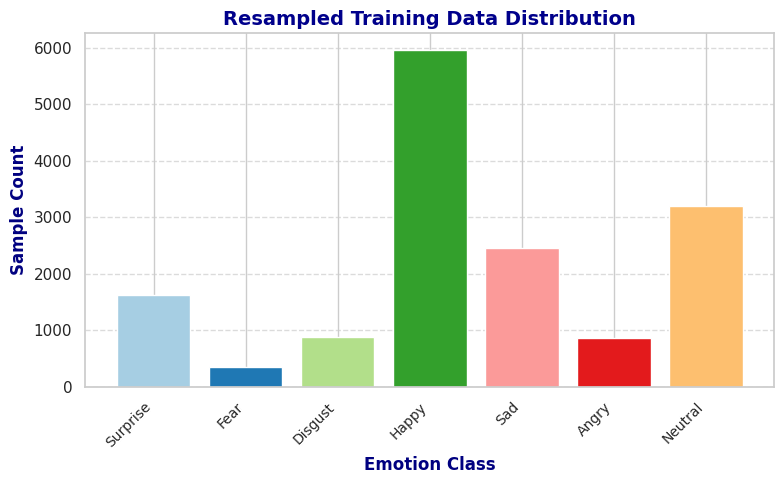

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Count occurrences of each class in the resampled training dataset
train_label_counts_resampled = Counter(Y_train)

# Extract sorted class labels and their corresponding counts
train_classes_resampled = sorted(train_label_counts_resampled.keys())
train_counts_resampled = [train_label_counts_resampled[cls] for cls in train_classes_resampled]

# Define figure size for the plot
plt.figure(figsize=(8, 5))

# Class labels for the x-axis
emotion_labels = ['Surprise', 'Fear', 'Disgust', 'Happy', 'Sad', 'Angry', 'Neutral']

# Create a bar chart showing resampled data distribution with improved color palette
bars = plt.bar(emotion_labels, train_counts_resampled, color=plt.cm.Paired(range(len(emotion_labels))))

# Add gridlines to make the plot easier to read
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Configure plot aesthetics
plt.xlabel("Emotion Class", fontsize=12, fontweight='bold', color='navy')
plt.ylabel("Sample Count", fontsize=12, fontweight='bold', color='navy')
plt.title("Resampled Training Data Distribution", fontsize=14, fontweight='bold', color='darkblue')

# Adjust the x-ticks for better spacing
plt.xticks(rotation=45, ha='right', fontsize=10)

# Make the plot layout tight and clean
plt.tight_layout()

# Render the plot
plt.show()


In [ ]:
# Shuffle X_train and Y_train
X_train, Y_train = shuffle(X_train, Y_train, random_state=42)

# Display the shapes to confirm the data is shuffled
print(X_train.shape)
print(Y_train.shape)

(15339, 100, 100, 3)
(15339,)


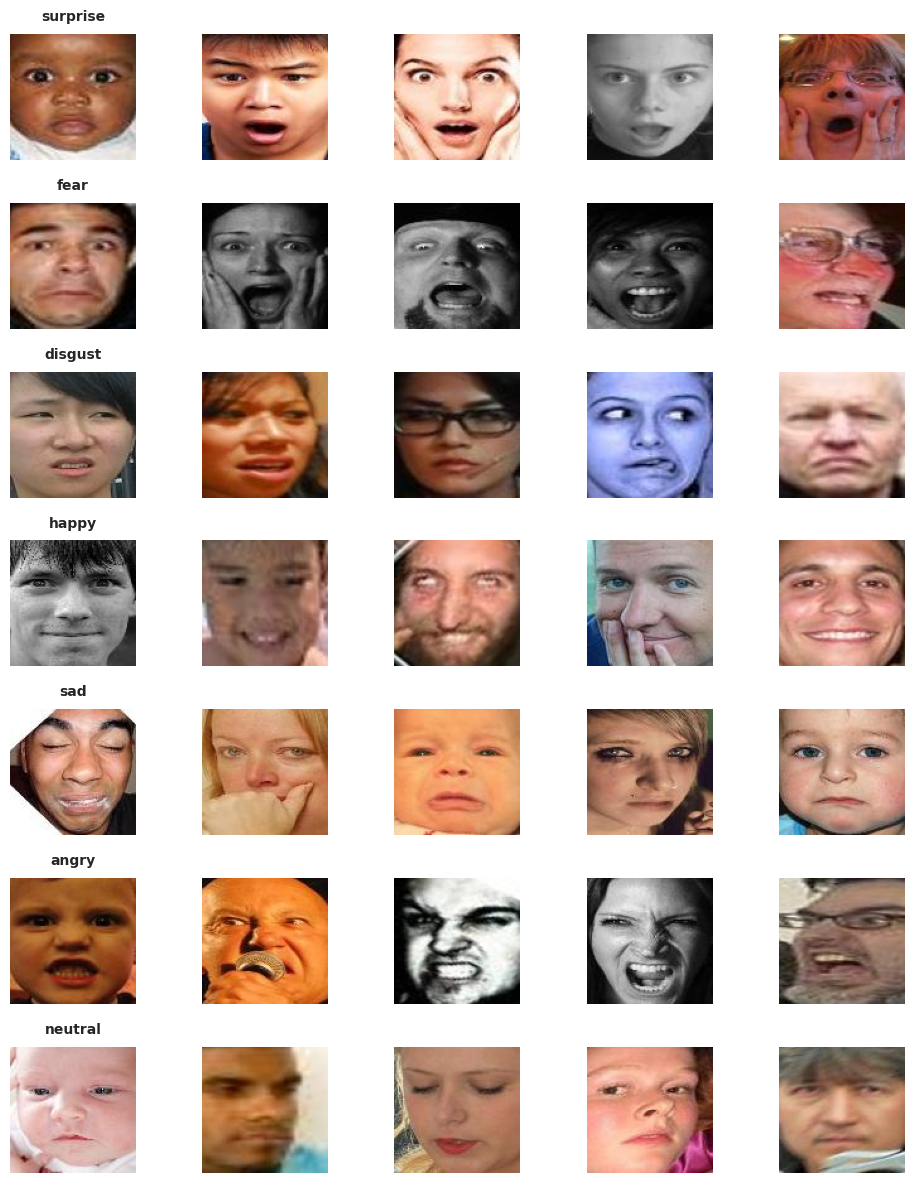

In [ ]:
def show_examples(train_images, train_labels, labels, num_examples=5):
    num_classes = len(labels)
    fig, axes = plt.subplots(num_classes, num_examples, figsize=(10, 12))

    for i, class_name in enumerate(labels):
        # Find indices of images belonging to the current class
        class_indices = [idx for idx, label in enumerate(train_labels) if label == i + 1]
        chosen_indices = np.random.choice(class_indices, num_examples, replace=False)

        # Set title for the first column in each row
        axes[i, 0].set_title(class_name, fontsize=10, pad=10, fontweight='bold')

        # Display selected images for the current class
        for j, idx in enumerate(chosen_indices):
            img = train_images[idx]
            axes[i, j].imshow(img)
            axes[i, j].axis("off")

    plt.tight_layout()
    plt.show()

# Display sample images for each class
show_examples(X_train, Y_train, classes)


In [ ]:
# most frequent image sizes :
train_data_shapes = []
for img in X_train:
  train_data_shapes.append(img.shape)
# Count occurrences for each size
shape_counts = {}
for shape in train_data_shapes:
  if shape not in shape_counts:
    shape_counts[shape] = 0
  shape_counts[shape] += 1
# Sort shapes by count
sorted_shapes = sorted(shape_counts.items(), key=lambda x: x[1], reverse=True)
# show most frequent size
print("Most frequent Train images shapes:")
for shape, count in sorted_shapes[:3]:
  print(f"- {shape}: {count}")

Most frequent Train images shapes:
- (100, 100, 3): 15339


In [ ]:
# Function to plot the class distribution
def plot_class_distribution(y, title):
    # Count the distribution of classes in the resampled train dataset
    train_label_counts_resampled = Counter(y)

    # Convert to sorted lists for plotting
    train_classes_resampled = sorted(train_label_counts_resampled.keys())
    train_counts_resampled = [train_label_counts_resampled[cls] for cls in train_classes_resampled]

    # Plot the distribution
    plt.figure(figsize=(6, 3))
    x_labels = ['Surprise', 'Fear', 'Disgust', 'Happy', 'Sad', 'Angry', 'Neutral']

    # Bar plot for the resampled distribution
    plt.bar(x_labels, train_counts_resampled, color="steelblue")

    # Add labels and title
    plt.xlabel("Emotion Class")
    plt.ylabel("Number of Examples")
    plt.title(title)
    plt.tight_layout()

    # Show the plot
    plt.show()

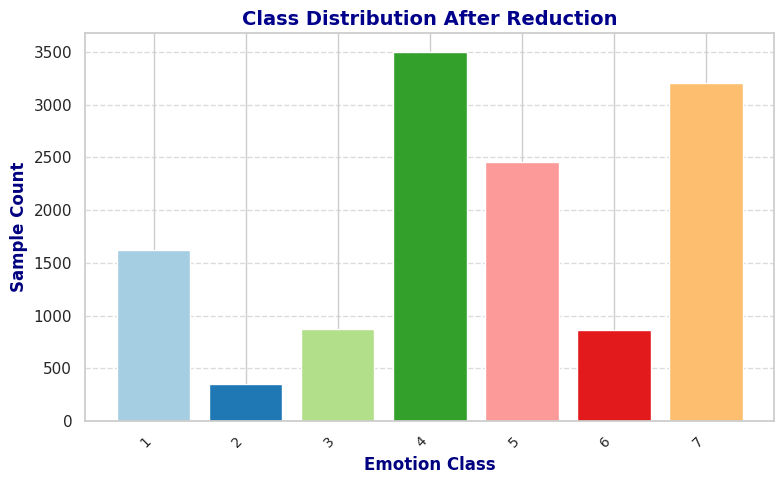

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def reduce_class_samples(X, y, target_class, target_size):
    class_indices = np.where(y == target_class)[0]
    non_class_indices = np.where(y != target_class)[0]
    reduced_class_indices = np.random.choice(class_indices, target_size, replace=False)
    final_indices = np.concatenate((reduced_class_indices, non_class_indices))
    X_reduced = X[final_indices]
    y_reduced = y[final_indices]
    return X_reduced, y_reduced

def plot_class_distribution(y, title="Class Distribution"):
    label_counts = Counter(y)
    classes = sorted(label_counts.keys())
    counts = [label_counts[cls] for cls in classes]
    plt.figure(figsize=(8, 5))
    bars = plt.bar(classes, counts, color=plt.cm.Paired(range(len(classes))))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xlabel("Emotion Class", fontsize=12, fontweight='bold', color='navy')
    plt.ylabel("Sample Count", fontsize=12, fontweight='bold', color='navy')
    plt.title(title, fontsize=14, fontweight='bold', color='darkblue')
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.tight_layout()
    plt.show()

target_class = 4
target_size = 3500
X_train_reduced, y_train_reduced = reduce_class_samples(X_train, Y_train, target_class, target_size)
plot_class_distribution(y_train_reduced, "Class Distribution After Reduction")


Class 1: augmenting 1881 samples.
Class 2: augmenting 3145 samples.
Class 3: augmenting 2623 samples.
Class 5: augmenting 1040 samples.
Class 6: augmenting 2633 samples.
Class 7: augmenting 296 samples.


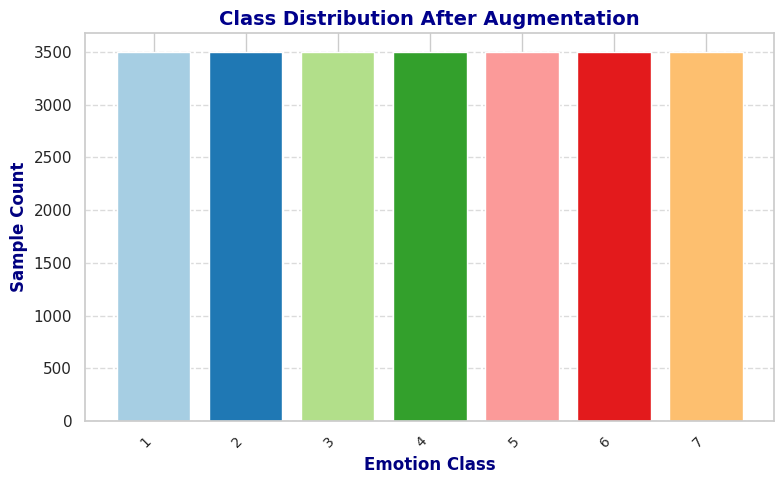

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Function to augment the dataset for each class
def augment_classes(images, labels, target_counts, batch_size=32):
    # Initialize image augmentation settings
    datagen = ImageDataGenerator(
        rotation_range=10,             # Random rotation
        width_shift_range=0.1,         # Random horizontal shift
        height_shift_range=0.1,        # Random vertical shift
        zoom_range=0.1,                # Random zoom
        vertical_flip=False,           # No vertical flip
        horizontal_flip=True,          # Random horizontal flip
        channel_shift_range=50.0,      # Random channel shift
        fill_mode='nearest'            # Fill pixels with the nearest value
    )

    augmented_images = images.copy()  # Copy original images to keep them unchanged
    augmented_labels = labels.copy()  # Copy original labels

    # Iterate over each class to augment it
    for target_class, target_count in target_counts.items():
        # Filter images and labels for the target class
        class_images = images[labels == target_class]
        class_labels = labels[labels == target_class]

        # Calculate how many samples we need to augment
        augment_count = target_count - len(class_images)

        if augment_count > 0:
            print(f'Class {target_class}: augmenting {augment_count} samples.')

            # Create an iterator for the augmented images of the target class
            class_images_augmented = []
            class_labels_augmented = []

            # Apply augmentation iteratively
            for batch in datagen.flow(class_images, batch_size=batch_size, seed=42):
                for img in batch:
                    class_images_augmented.append(img.astype(np.uint8))
                    class_labels_augmented.append(target_class)

                    # Stop once we reach the target augmentation count
                    if len(class_images_augmented) >= augment_count:
                        break
                if len(class_images_augmented) >= augment_count:
                    break

            # Add the augmented images and labels to the dataset
            augmented_images = np.vstack((augmented_images, np.array(class_images_augmented)))
            augmented_labels = np.hstack((augmented_labels, np.array(class_labels_augmented)))

    return augmented_images, augmented_labels


# Example usage
target_counts = {1: 3500, 2: 3500, 3: 3500, 5: 3500, 6: 3500, 7: 3500}  # Target counts for each class
X_train_augmented, y_train_augmented = augment_classes(X_train_reduced, y_train_reduced, target_counts)

# Visualize the class distribution after augmentation
plot_class_distribution(y_train_augmented, "Class Distribution After Augmentation")



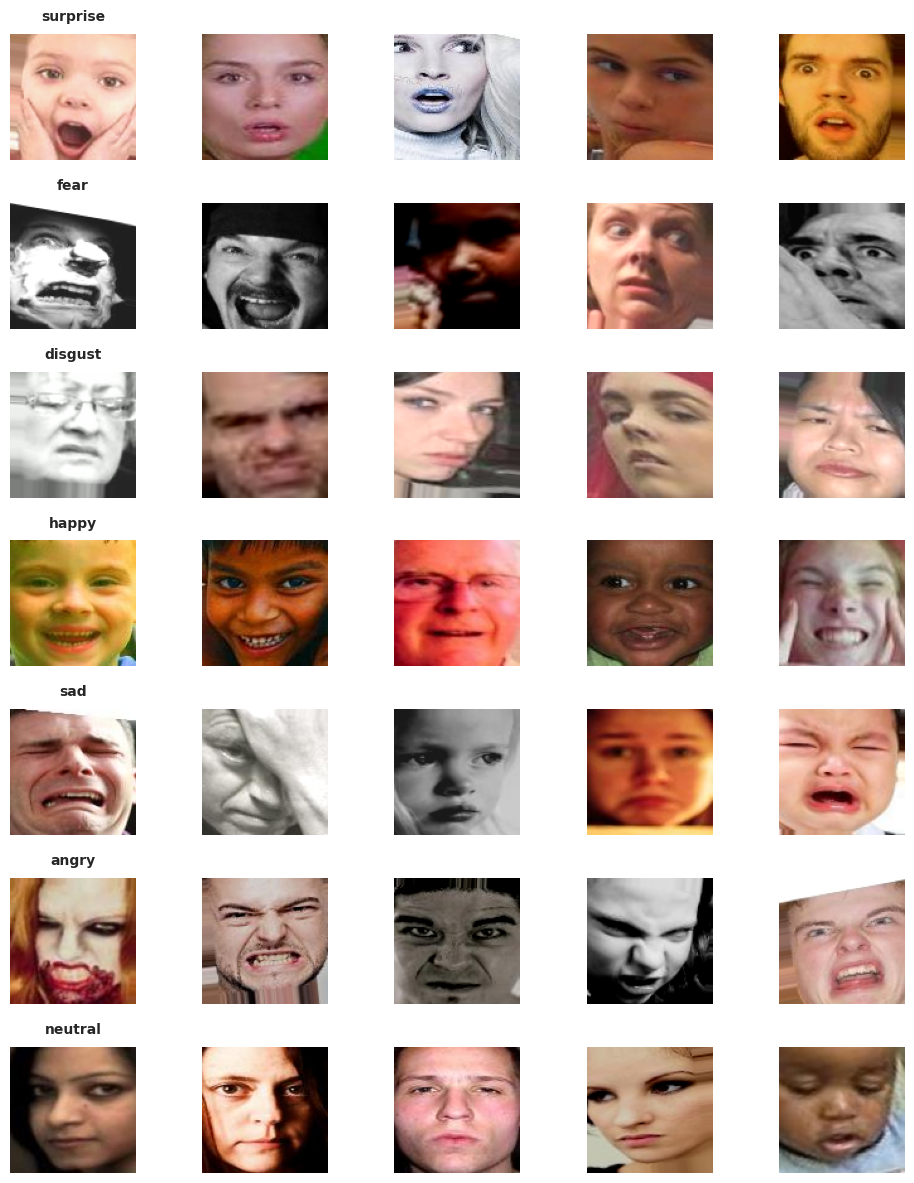

In [ ]:
# Show sample images for each class
show_examples(X_train_augmented, y_train_augmented, classes)

**Split**



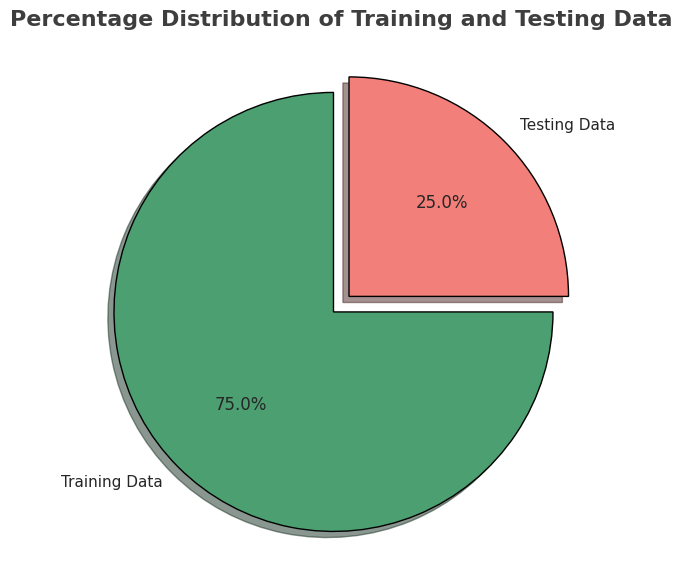

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def split_data(X, y, test_size=0.25, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True, random_state=random_state)
    return X_train, X_test, y_train, y_test

X_train_split, X_test_split, Y_train_split, Y_test_split = split_data(X_train_augmented, y_train_augmented, test_size=0.25, random_state=42)

total_images = len(X_train_split) + len(X_test_split)

train_percentage = (len(X_train_split) / total_images) * 100
test_percentage = (len(X_test_split) / total_images) * 100

labels = ['Training Data', 'Testing Data']
sizes = [train_percentage, test_percentage]
colors = ['#4C9F70', '#F27F79']  # New polished colors
explode = (0.1, 0)  # Slightly explode the first slice (training data) for emphasis

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, explode=explode, wedgeprops={'edgecolor': 'black', 'linewidth': 1, 'linestyle': 'solid'}, shadow=True)

plt.title('Percentage Distribution of Training and Testing Data', fontsize=16, fontweight='bold', color='#3E3E3E', fontname='Arial')
plt.axis('equal')
plt.tight_layout()
plt.show()


**2. Normalize the images**

In [ ]:
def normalize_images(images):
    # Normalize pixel values to [0, 1]
    return images / 255.0

train_images_normalized = normalize_images(X_train_split)
test_images_normalized = normalize_images(X_test_split)

**3. Reshape the images**

In [ ]:
def reshape_images(images, model_type='CNN'):
    if model_type == 'SVM':
        # SVM needs the images to be flattened (1D)
        return images.reshape((images.shape[0], -1))
    elif model_type in ['CNN']:
        # CNN and DenseNet require images to have shape (height, width, channels)
        return images.reshape((images.shape[0], 100, 100, 3))

train_images_SVMreshaped = reshape_images(train_images_normalized, model_type='SVM')
test_images_SVMreshaped = reshape_images(test_images_normalized, model_type='SVM')

train_images_CNNreshaped = reshape_images(train_images_normalized, model_type='CNN')
test_images_CNNreshaped = reshape_images(test_images_normalized, model_type='CNN')

In [ ]:
# Convert labels to categorical for CNN
Y_train_cat = to_categorical(Y_train_split - 1, num_classes=len(classes))
Y_test_cat = to_categorical(Y_test_split - 1, num_classes=len(classes))

# Verify the one-hot encoded labels
print("One-hot encoded train labels shape:", Y_train_cat.shape)
print("One-hot encoded test labels shape:", Y_test_cat.shape)


One-hot encoded train labels shape: (18375, 7)
One-hot encoded test labels shape: (6125, 7)


In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    vertical_flip=False,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create the generator for training
train_generator = datagen.flow(train_images_CNNreshaped, Y_train_cat, batch_size=64)

Label distribution for Final Training Set Distribution:
Label 1: 2630 samples
Label 2: 2660 samples
Label 3: 2590 samples
Label 4: 2613 samples
Label 5: 2635 samples
Label 6: 2641 samples
Label 7: 2606 samples


<ipython-input-24-9116195fa6ae>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique_labels, y=label_counts, palette="viridis")


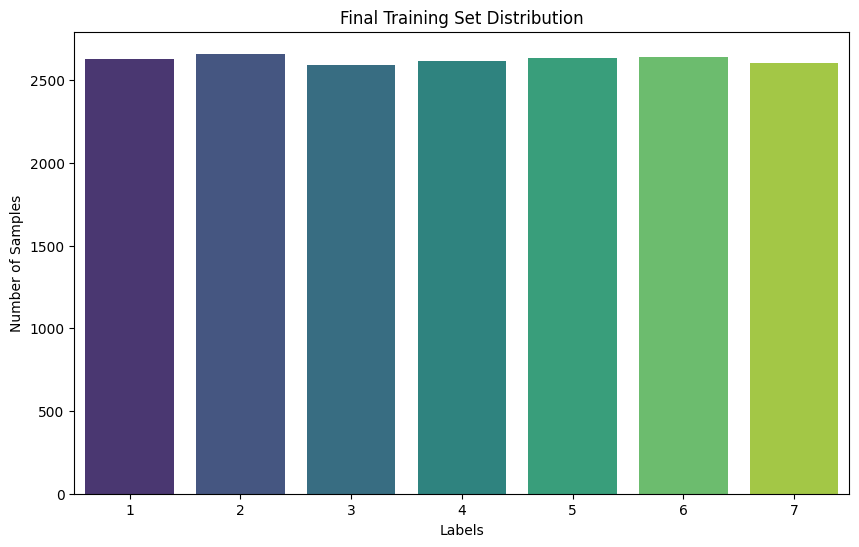

Label distribution for Final Testing Set Distribution:
Label 1: 870 samples
Label 2: 840 samples
Label 3: 910 samples
Label 4: 887 samples
Label 5: 865 samples
Label 6: 859 samples
Label 7: 894 samples


<ipython-input-24-9116195fa6ae>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique_labels, y=label_counts, palette="viridis")


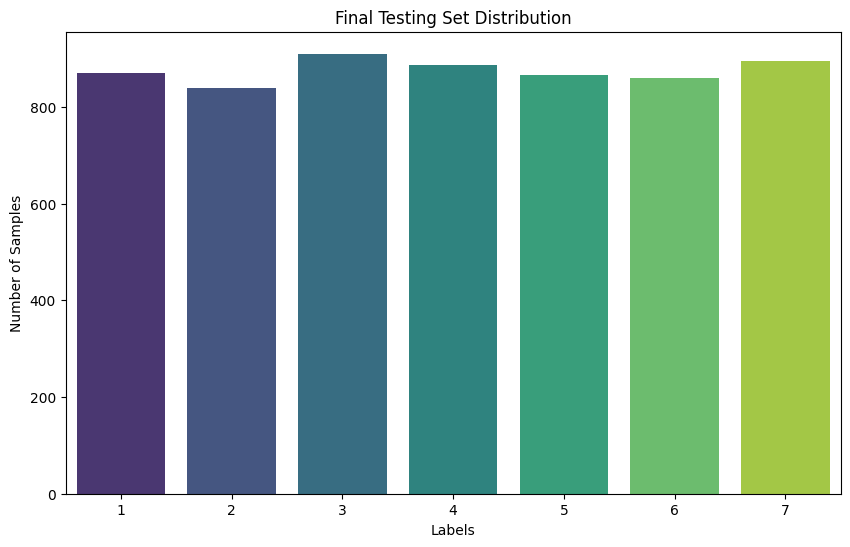

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Function to plot and print class distribution
def plot_class_distribution(labels, title):
    # Count the number of occurrences of each label
    unique_labels, label_counts = np.unique(labels, return_counts=True)

    # Print the total number of samples in each class
    print(f"Label distribution for {title}:")
    for label, count in zip(unique_labels, label_counts):
        print(f"Label {label}: {count} samples")

    # Plotting the class distribution
    plt.figure(figsize=(10, 6))
    sns.barplot(x=unique_labels, y=label_counts, palette="viridis")
    plt.title(title)
    plt.xlabel('Labels')
    plt.ylabel('Number of Samples')
    plt.show()

# Plot and print class distribution for training and testing datasets
plot_class_distribution(Y_train_split, "Final Training Set Distribution")
plot_class_distribution(Y_test_split, "Final Testing Set Distribution")


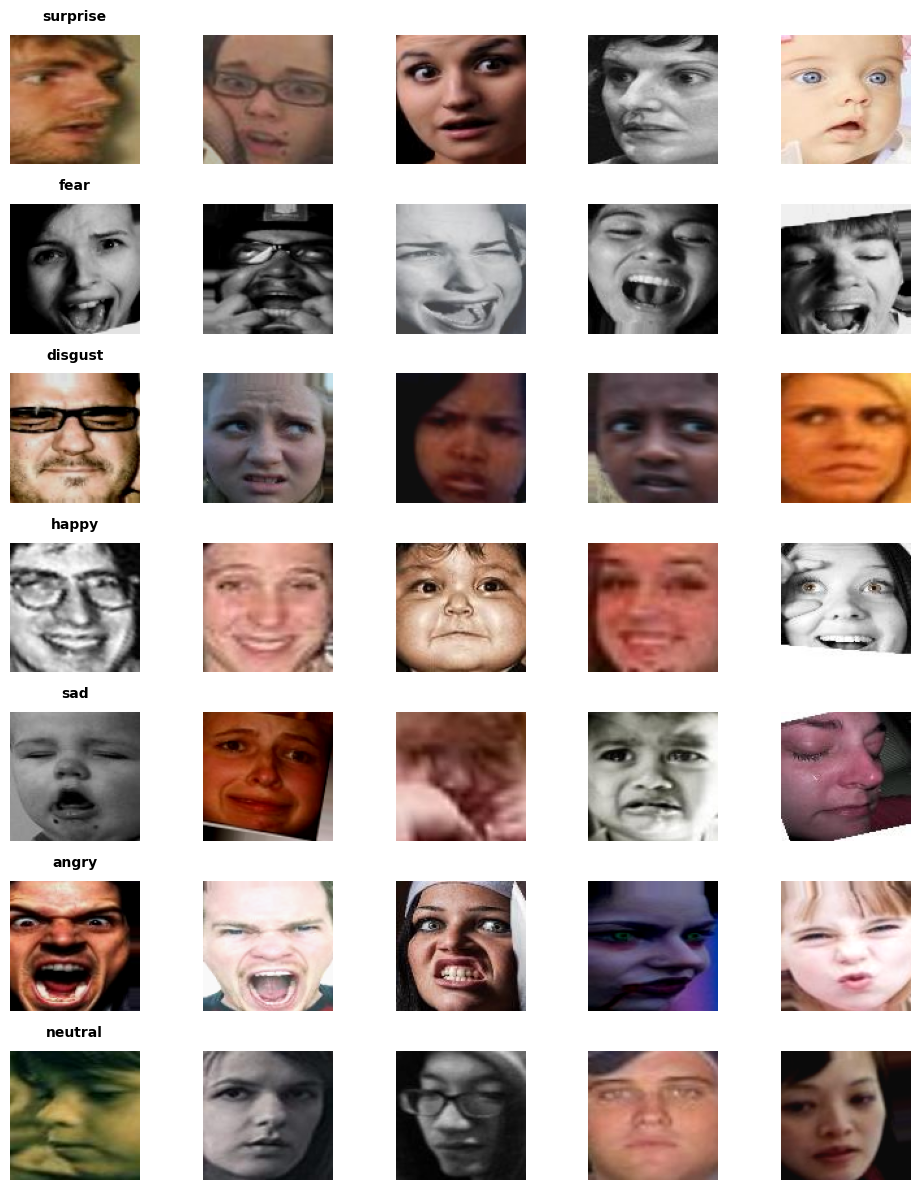

In [ ]:
show_examples(X_train_split, Y_train_split, classes)


In [ ]:
import os
import pandas as pd

train_labels_path = os.path.join(shuvoalok_raf_db_dataset_path, "train_labels.csv")

# Define a mapping for label numbers to label names

label_name_mapping = {
    0: 'Anger',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happiness',
    4: 'Sadness',
    5: 'Surprise',
    6: 'Neutral'
}

# Ensure the file exists
if os.path.exists(train_labels_path):
    train_labels = pd.read_csv(train_labels_path)

    # Print the first few rows of the dataframe
    print(train_labels.head())

    # Print label number and corresponding label name
    if 'label' in train_labels.columns:
        print("\nLabel Number and Name:")
        for label in train_labels['label'].unique():
            label_name = label_name_mapping.get(label, "Unknown")  # Get label name from mapping
            print(f"Label {label}: {label_name}")
    else:
        print("\n'Label' column not found in train_labels.csv.")
else:
    print("Error: train_labels.csv not found.")

                     image  label
0  train_00001_aligned.jpg      5
1  train_00002_aligned.jpg      5
2  train_00003_aligned.jpg      4
3  train_00004_aligned.jpg      4
4  train_00005_aligned.jpg      5

Label Number and Name:
Label 5: Surprise
Label 4: Sadness
Label 1: Disgust
Label 6: Neutral
Label 2: Fear
Label 3: Happiness
Label 7: Unknown


# ResNet 18

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Define Dataset Class
class RAFDBDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform
        self.images = []
        self.labels = []
        for label_folder in os.listdir(data_path):
            label_folder_path = os.path.join(data_path, label_folder)
            if os.path.isdir(label_folder_path):
                label = int(label_folder) - 1
                for file in os.listdir(label_folder_path):
                    if file.endswith(('.jpg', '.png')):
                        self.images.append(os.path.join(label_folder_path, file))
                        self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = self.labels[idx]
        return img, label

# Load dataset
dataset_dir = os.path.join(shuvoalok_raf_db_dataset_path, "DATASET")
train_dir = os.path.join(dataset_dir, "train")
test_dir = os.path.join(dataset_dir, "test")

train_data = RAFDBDataset(train_dir, transform=transform)
test_data = RAFDBDataset(test_dir, transform=transform)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to get ResNet model with Dropout
def get_resnet(model_type="resnet18", num_classes=7):
    if model_type == "resnet18":
        model = models.resnet18(pretrained=True)
    elif model_type == "resnet32":
        model = models.resnet34(pretrained=True)

    in_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.5),  # Added Dropout to prevent overfitting
        nn.Linear(in_features, num_classes)
    )
    return model.to(device)

# Choose model
model = get_resnet("resnet18")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# ReduceLROnPlateau Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

# Early Stopping Parameters
num_epochs = 20
patience = 7
best_test_loss = float('inf')
stagnant_epochs = 0
train_losses, test_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    train_losses.append(running_loss / len(train_loader))
    print(f"Epoch {epoch+1}, Loss: {train_losses[-1]:.4f}, Accuracy: {train_acc:.2f}%")

    # Evaluate on test set
    model.eval()
    test_loss = 0.0
    y_true, y_pred, y_scores = [], [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_scores.extend(torch.nn.functional.softmax(outputs, dim=1).cpu().numpy())

    test_losses.append(test_loss / len(test_loader))
    scheduler.step(test_losses[-1])  # Update LR based on test loss
    print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

    # Early Stopping Check
    if test_losses[-1] < best_test_loss:
        best_test_loss = test_losses[-1]
        stagnant_epochs = 0
        torch.save(model.state_dict(), "best_model.pth")  # Save the best model
    else:
        stagnant_epochs += 1
        if stagnant_epochs >= patience:
            print("Early stopping triggered. Loading best model...")
            model.load_state_dict(torch.load("best_model.pth"))
            break

# Plot Training vs Testing Loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(test_losses) + 1), test_losses, label="Testing Loss", marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs. Testing Loss")
plt.legend()
plt.grid()
plt.show()

# Test Accuracy
test_acc = 100 * np.mean(np.array(y_true) == np.array(y_pred))
print(f"Test Accuracy: {test_acc:.2f}%")

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# ROC Curve & AUC
class_names = ["Surprise", "Fear", "Disgust", "Happy", "Sad", "Angry", "Neautral"]
plt.figure(figsize=(8, 6))
for i in range(7):  # Assuming 7 classes
    fpr, tpr, _ = roc_curve(np.array(y_true) == i, np.array(y_scores)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Save Model
torch.save(model.state_dict(), "resnet18_rafdb.pth")
model.load_state_dict(torch.load("resnet18_rafdb.pth"))
model.eval()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 175MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

KeyboardInterrupt: 

# InceptionV3

In [ ]:
#title Check train & test images
import matplotlib.pyplot as plt

def show_images(X, Y, num_images=5, title="Sample Images"):
    """
    Display the first `num_images` images with their corresponding labels.

    Parameters:
    - X: Image data (NumPy array or Tensor)
    - Y: Corresponding labels
    - num_images: Number of images to display (default: 5)
    - title: Title for the image set (default: 'Sample Images')
    """
    plt.figure(figsize=(10, 5))
    for i in range(min(num_images, len(X))):  # Avoid out-of-bounds errors
        plt.subplot(1, num_images, i + 1)
        plt.imshow(X[i])
        plt.title(f"Label: {Y[i]}")
        plt.axis('off')
    plt.suptitle(title)  # Set overall title
    plt.show()


print(type(X_train_split))
print(X_train_split.shape)
print(type(Y_train_split))
print(Y_train_split.shape)

print(type(X_test_split))
print(X_test_split.shape)
print(type(Y_test_split))
print(Y_test_split.shape)


print("Y_train_split (train_labels) first 5 data:", Y_train_split[:5])
print("Y_test_split (test_labels) first 5 data:", Y_test_split[:5])

# Call the function to display the first 5 images from the training set
show_images(X_train_split, Y_train_split, num_images=5, title="Training Set")

# Also, display the first 5 images from the test set
show_images(X_test_split, Y_test_split, num_images=5, title="Test Set")


NameError: name 'X_train_split' is not defined

In [ ]:
import torch
import torchvision.datasets as datasets
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import random_split

import torch.nn as nn
import torch.optim as optim
from torchvision import models

from PIL import Image
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 32

class CustomImageDataset(Dataset):
    def __init__(self, X, Y, transform=None):
        """
        X: NumPy array of images with shape (N, H, W, C)
        Y: NumPy array of labels
        transform: torchvision.transforms to apply on each image
        """
        self.X = X
        self.Y = Y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Convert the image at index idx to PIL image
        img = Image.fromarray(np.uint8(self.X[idx]))
        if self.transform:
            img = self.transform(img)
        label = self.Y[idx]
        return img, label

from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize to 299x299
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

# Create dataset and DataLoader (this loads data on-the-fly)
train_dataset = CustomImageDataset(X_train_split, Y_train_split - 1, transform=transform)

# Calculate the size of the split (assuming 80% for training and 20% for validation)
train_size = int(0.8 * len(train_dataset))
valid_size = len(train_dataset) - train_size

# Use random_split to split
train_dataset, valid_dataset = random_split(train_dataset, [train_size, valid_size])

# create DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)


test_dataset = CustomImageDataset(X_test_split, Y_test_split - 1, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [ ]:

# Load the pretrained InceptionV3 model
model = models.inception_v3(pretrained=True)
num_ftrs = model.fc.in_features
# Replace the fully connected layer to fit our 7-class classification task
model.fc = nn.Linear(num_ftrs, 7)  # 7 classes
model = model.to(device)

# loss function
criterion = nn.CrossEntropyLoss()

train_losses = []
valid_accuracies = []

# Define the training function
def train_model(model, train_loader, val_loader, num_epochs, stage, optimizer):
    """ Train the model and record the loss and accuracy """
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            if hasattr(outputs, 'logits'):
                outputs = outputs.logits

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)  # Recording training loss

        # Calculate the validation set accuracy
        val_acc = evaluate_model(model, val_loader)
        valid_accuracies.append(val_acc)  # Record the validation set accuracy

        print(f"Stage {stage}, Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}, Valid Accuracy: {val_acc:.2f}%")

        # Save the best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f"best_model_stage_{stage}.pth")

# Evaluation Model FUNCTION
def evaluate_model(model, val_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            if hasattr(outputs, 'logits'):
                outputs = outputs.logits

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total



# Plotting Loss and Accuracy Curves
def plot_results():
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # plotting Loss curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()

    # plotting Accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, valid_accuracies, 'g-', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Validation Accuracy Curve')
    plt.legend()

    plt.show()


In [ ]:
# phrase 1 -- Only optimize the fully connected layers
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
train_model(model, train_loader, valid_loader, num_epochs=5, stage=1, optimizer=optimizer)

# phrase 2
for param in model.parameters():
    param.requires_grad = False
for name, param in model.named_parameters():
    if "Mixed_6a" in name or "Mixed_7a" in name:
        param.requires_grad = True

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)
train_model(model, train_loader, valid_loader, num_epochs=30, stage=2, optimizer=optimizer)


#phrase 3
for param in model.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model.parameters(), lr=0.00005)
train_model(model, train_loader, valid_loader, num_epochs=15, stage=3, optimizer=optimizer)


plot_results()

## Unified training model

In [ ]:

# Load the pretrained InceptionV3 model
model = models.inception_v3(pretrained=True)
num_ftrs = model.fc.in_features
# Replace the fully connected layer to fit our 7-class classification task
model.fc = nn.Linear(num_ftrs, 7)  # 7 classes
model = model.to(device)


# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
# 0.001 -》 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # lr: learning rate

# loss array
train_losses = []
valid_losses = []
valid_accuracies = []

# training
num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        # print("images' shape: ", images.shape)
        # print("label's shape: ", labels.shape)
        # print("labels: ", labels)

        # Forward pass
        outputs = model(images)
        logits = outputs.logits if hasattr(outputs, 'logits') else outputs
        loss = criterion(logits, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        # Apply gradient clipping to prevent explosion
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step() # update parameters

        train_loss += loss.item()

    # Calculate the training set loss
    train_loss = train_loss / len(train_loader)
    train_losses.append(train_loss) # save loss value in each epoch

    # Evaluated on the validation set
    model.eval()  # eval mode
    valid_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():  # Gradients are not calculated during evaluation
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            logits = outputs.logits if hasattr(outputs, 'logits') else outputs
            loss = criterion(logits, labels)
            valid_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    valid_loss /= len(valid_loader)
    valid_losses.append(valid_loss)

    valid_acc = 100 * correct / total
    valid_accuracies.append(valid_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Valid Accuracy: {valid_acc:.2f}%")
    # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# plot the loss curve after training
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, num_epochs+1), valid_losses, label='Valid Loss', marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.show()

# plot the Accuracy curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), valid_accuracies, label='Valid Accuracy', marker='d', color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy")
plt.legend()
plt.grid()
plt.show()

# save model
torch.save(model.state_dict(), 'inception_v3.pth')


## Model Test

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# eval mode
model.eval()


# results arrays
all_preds = []
all_labels = []


# Disable gradient calculation for testing
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # prediction
        outputs = model(images)
        # logits = outputs.logits

        # 获取预测类别
        _, preds = torch.max(outputs, 1)

        # 记录预测结果
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

# 合并所有 batch 的数据
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

# 计算整体准确率
correct = (all_preds == all_labels).sum().item()
total = all_labels.size(0)
overall_accuracy = correct / total * 100
print(f'Overall Accuracy: {overall_accuracy:.2f}%')

# 类别名称映射
# class_map = {'surprise': 1, 'fear': 2, 'disgust': 3, 'happy': 4,
#              'sad': 5, 'angry': 6, 'neutral': 7}

index_to_class = {v: k for k, v in label_map.items()}  # 反转映射
print("index_to_class: ", index_to_class)
class_names = [index_to_class[i] for i in range(1, len(label_map) + 1)]
print("class_names : ", class_names)

# 计算混淆矩阵
cm = confusion_matrix(all_labels, all_preds)

# 绘制混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 计算分类报告（Precision, Recall, F1-score）
report = classification_report(all_labels, all_preds, target_names=class_names, digits=4)
print("Classification Report:\n")
print(report)

# 计算每个类别的分类准确率（Accuracy = 该类别正确分类的样本数 / 该类别的总样本数）
class_accuracies = cm.diagonal() / cm.sum(axis=1)

# 打印每个类别的分类准确率
print("\nPer-Class Accuracy:")
for i, class_name in enumerate(class_names):
    print(f"{class_name}: {class_accuracies[i] * 100:.2f}%")


# VGG16

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tqdm import tqdm

# Define transformations (adjust for VGG16 input size)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # VGG16 expects 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet normalization
])

class RAFDBDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform
        self.images = []
        self.labels = []
        for label_folder in os.listdir(data_path):
            label_folder_path = os.path.join(data_path, label_folder)
            if os.path.isdir(label_folder_path):
                label = int(label_folder) - 1
                for file in os.listdir(label_folder_path):
                    if file.endswith(('.jpg', '.png')):
                        self.images.append(os.path.join(label_folder_path, file))
                        self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = self.labels[idx]
        return img, label

# Load dataset
# shuvoalok_raf_db_dataset_path = shuvoalok_raf_db_dataset_path  # Path from KaggleHub
dataset_dir = os.path.join(shuvoalok_raf_db_dataset_path, "DATASET")
train_dir = os.path.join(dataset_dir, "train")
test_dir = os.path.join(dataset_dir, "test")

train_data = RAFDBDataset(train_dir, transform=transform)
test_data = RAFDBDataset(test_dir, transform=transform)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2) # Added num_workers for faster loading in Colab
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to get VGG16 model with Dropout
def get_vgg16(num_classes=7, pretrained=True):
    model = models.vgg16(pretrained=pretrained)
    # Freeze feature layers (optional for initial training)
    for param in model.features.parameters():
        param.requires_grad = False
    # Modify the classifier
    num_features = model.classifier[0].in_features
    model.classifier = nn.Sequential(
        nn.Linear(num_features, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5),
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5),
        nn.Linear(4096, num_classes)
    )
    return model.to(device)

# Choose model
model_vgg16 = get_vgg16(num_classes=7, pretrained=True)

criterion = nn.CrossEntropyLoss()
optimizer_vgg16 = optim.Adam(model_vgg16.classifier.parameters(), lr=0.0005) # Optimize only the classifier initially

# ReduceLROnPlateau Scheduler
scheduler_vgg16 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_vgg16, mode='min', patience=3, factor=0.5, verbose=True)

# Early Stopping Parameters
num_epochs = 20
patience = 7
best_test_loss_vgg16 = float('inf')
stagnant_epochs_vgg16 = 0
train_losses_vgg16, test_losses_vgg16 = [], []

print("Starting VGG16 Training...")

for epoch in range(num_epochs):
    model_vgg16.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Train)"):
        images, labels = images.to(device), labels.to(device)
        optimizer_vgg16.zero_grad()
        outputs = model_vgg16(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_vgg16.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    train_losses_vgg16.append(running_loss / len(train_loader))
    print(f"Epoch {epoch+1}, Train Loss: {train_losses_vgg16[-1]:.4f}, Accuracy: {train_acc:.2f}%")

    # Evaluate on test set
    model_vgg16.eval()
    test_loss = 0.0
    y_true_vgg16, y_pred_vgg16, y_scores_vgg16 = [], [], []
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Test)"):
            images, labels = images.to(device), labels.to(device)
            outputs = model_vgg16(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            y_true_vgg16.extend(labels.cpu().numpy())
            y_pred_vgg16.extend(predicted.cpu().numpy())
            y_scores_vgg16.extend(torch.nn.functional.softmax(outputs, dim=1).cpu().numpy())

    test_losses_vgg16.append(test_loss / len(test_loader))
    scheduler_vgg16.step(test_losses_vgg16[-1])  # Update LR based on test loss
    print(f"Epoch {epoch+1}, Train Loss: {train_losses_vgg16[-1]:.4f}, Test Loss: {test_losses_vgg16[-1]:.4f}")

    # Early Stopping Check
    if test_losses_vgg16[-1] < best_test_loss_vgg16:
        best_test_loss_vgg16 = test_losses_vgg16[-1]
        stagnant_epochs_vgg16 = 0
        torch.save(model_vgg16.state_dict(), "best_model_vgg16.pth")  # Save the best VGG16 model
    else:
        stagnant_epochs_vgg16 += 1
        if stagnant_epochs_vgg16 >= patience:
            print("Early stopping triggered for VGG16. Loading best model...")
            model_vgg16.load_state_dict(torch.load("best_model_vgg16.pth"))
            break

print("VGG16 Training Finished.")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Starting VGG16 Training...


Epoch 1/20 (Train): 100%|██████████| 192/192 [00:17<00:00, 11.12it/s]


Epoch 1, Train Loss: 1.2146, Accuracy: 57.18%


Epoch 1/20 (Test): 100%|██████████| 48/48 [00:04<00:00, 10.23it/s]


Epoch 1, Train Loss: 1.2146, Test Loss: 0.9655


Epoch 2/20 (Train): 100%|██████████| 192/192 [00:16<00:00, 11.88it/s]


Epoch 2, Train Loss: 0.8073, Accuracy: 71.93%


Epoch 2/20 (Test): 100%|██████████| 48/48 [00:04<00:00, 11.49it/s]


Epoch 2, Train Loss: 0.8073, Test Loss: 0.8986


Epoch 3/20 (Train): 100%|██████████| 192/192 [00:15<00:00, 12.09it/s]


Epoch 3, Train Loss: 0.5412, Accuracy: 81.02%


Epoch 3/20 (Test): 100%|██████████| 48/48 [00:04<00:00, 10.96it/s]


Epoch 3, Train Loss: 0.5412, Test Loss: 0.9412


Epoch 4/20 (Train): 100%|██████████| 192/192 [00:16<00:00, 11.88it/s]


Epoch 4, Train Loss: 0.4020, Accuracy: 86.08%


Epoch 4/20 (Test): 100%|██████████| 48/48 [00:04<00:00, 11.29it/s]


Epoch 4, Train Loss: 0.4020, Test Loss: 1.0869


Epoch 5/20 (Train): 100%|██████████| 192/192 [00:16<00:00, 11.93it/s]


Epoch 5, Train Loss: 0.2901, Accuracy: 89.91%


Epoch 5/20 (Test): 100%|██████████| 48/48 [00:04<00:00, 11.72it/s]


Epoch 5, Train Loss: 0.2901, Test Loss: 1.1522


Epoch 6/20 (Train): 100%|██████████| 192/192 [00:15<00:00, 12.00it/s]


Epoch 6, Train Loss: 0.2355, Accuracy: 92.01%


Epoch 6/20 (Test): 100%|██████████| 48/48 [00:04<00:00, 11.11it/s]


Epoch 6, Train Loss: 0.2355, Test Loss: 1.2485


Epoch 7/20 (Train): 100%|██████████| 192/192 [00:16<00:00, 11.90it/s]


Epoch 7, Train Loss: 0.1321, Accuracy: 95.72%


Epoch 7/20 (Test): 100%|██████████| 48/48 [00:04<00:00, 11.25it/s]


Epoch 7, Train Loss: 0.1321, Test Loss: 1.1820


Epoch 8/20 (Train): 100%|██████████| 192/192 [00:16<00:00, 11.96it/s]


Epoch 8, Train Loss: 0.0845, Accuracy: 97.20%


Epoch 8/20 (Test): 100%|██████████| 48/48 [00:04<00:00, 11.66it/s]


Epoch 8, Train Loss: 0.0845, Test Loss: 1.3097


Epoch 9/20 (Train): 100%|██████████| 192/192 [00:16<00:00, 11.91it/s]


Epoch 9, Train Loss: 0.0752, Accuracy: 97.50%


Epoch 9/20 (Test): 100%|██████████| 48/48 [00:04<00:00, 10.89it/s]


Epoch 9, Train Loss: 0.0752, Test Loss: 1.3861
Early stopping triggered for VGG16. Loading best model...
VGG16 Training Finished.


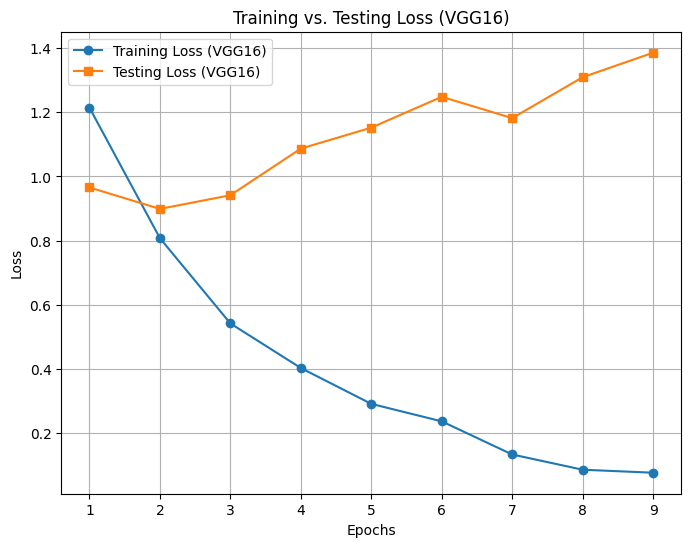

VGG16 Test Accuracy: 70.24%


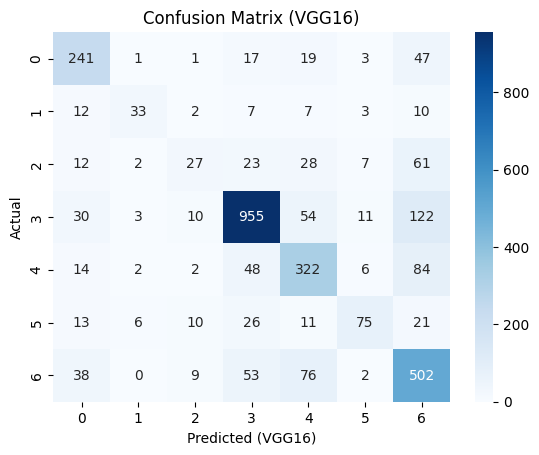

VGG16 Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.73      0.70       329
           1       0.70      0.45      0.55        74
           2       0.44      0.17      0.24       160
           3       0.85      0.81      0.83      1185
           4       0.62      0.67      0.65       478
           5       0.70      0.46      0.56       162
           6       0.59      0.74      0.66       680

    accuracy                           0.70      3068
   macro avg       0.65      0.58      0.60      3068
weighted avg       0.70      0.70      0.70      3068



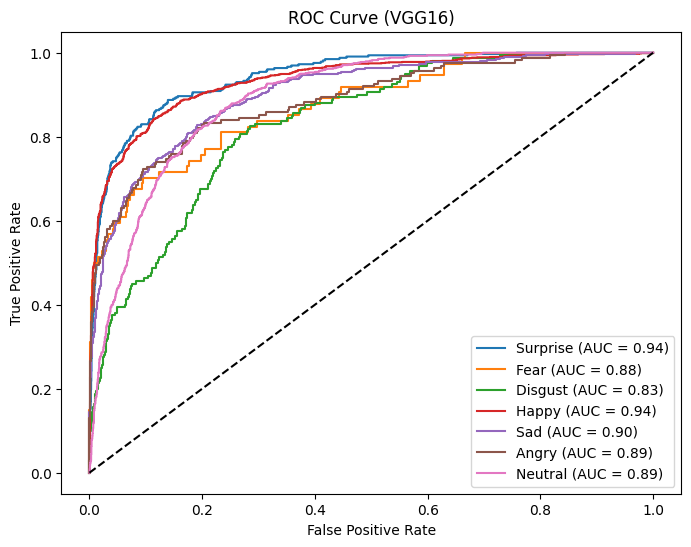

VGG16 Model Saved as vgg16_rafdb.pth


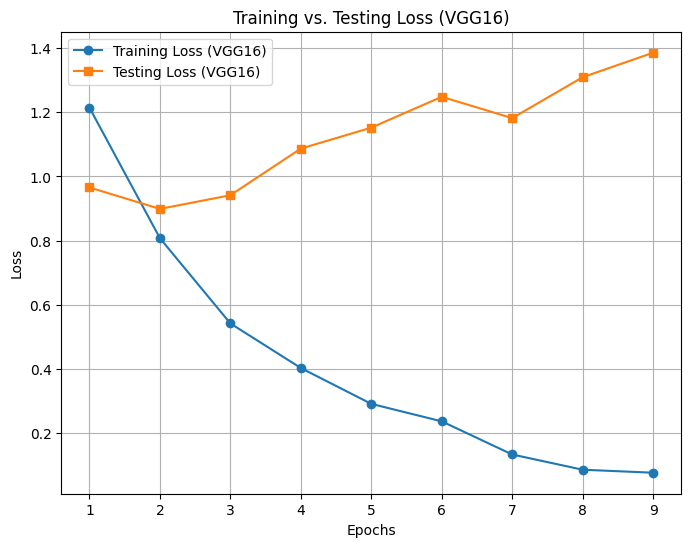

VGG16 Test Accuracy: 70.24%


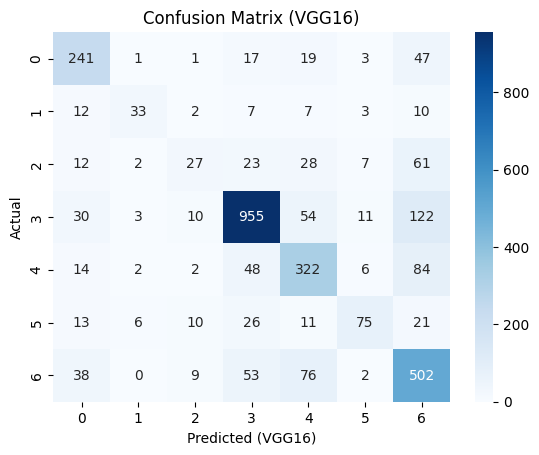

VGG16 Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.73      0.70       329
           1       0.70      0.45      0.55        74
           2       0.44      0.17      0.24       160
           3       0.85      0.81      0.83      1185
           4       0.62      0.67      0.65       478
           5       0.70      0.46      0.56       162
           6       0.59      0.74      0.66       680

    accuracy                           0.70      3068
   macro avg       0.65      0.58      0.60      3068
weighted avg       0.70      0.70      0.70      3068



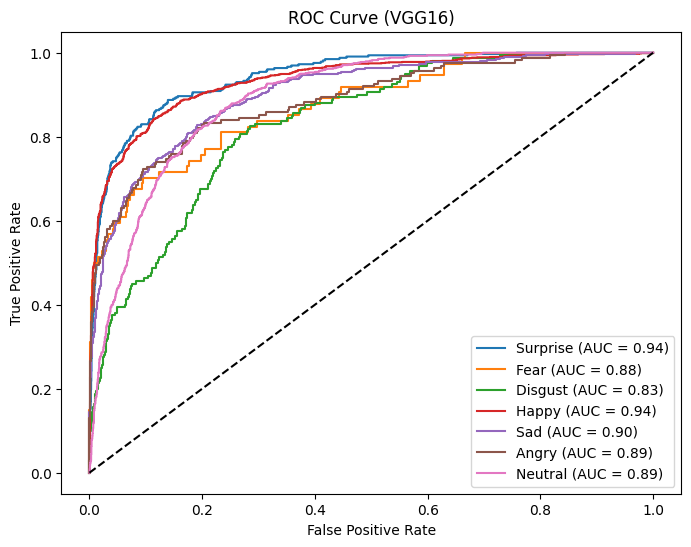

VGG16 Model Saved as vgg16_rafdb.pth


In [ ]:
# Plot Training vs Testing Loss for VGG16
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_losses_vgg16) + 1), train_losses_vgg16, label="Training Loss (VGG16)", marker='o')
plt.plot(range(1, len(test_losses_vgg16) + 1), test_losses_vgg16, label="Testing Loss (VGG16)", marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs. Testing Loss (VGG16)")
plt.legend()
plt.grid(True) #Fixed the syntax error here.
plt.show()

# Test Accuracy for VGG16
test_acc_vgg16 = 100 * np.mean(np.array(y_true_vgg16) == np.array(y_pred_vgg16))
print(f"VGG16 Test Accuracy: {test_acc_vgg16:.2f}%")

# Confusion Matrix for VGG16
conf_matrix_vgg16 = confusion_matrix(y_true_vgg16, y_pred_vgg16)
sns.heatmap(conf_matrix_vgg16, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted (VGG16)")
plt.ylabel("Actual")
plt.title("Confusion Matrix (VGG16)")
plt.show()

# Classification Report for VGG16
print("VGG16 Classification Report:")
print(classification_report(y_true_vgg16, y_pred_vgg16))

# ROC Curve & AUC for VGG16
class_names = ["Surprise", "Fear", "Disgust", "Happy", "Sad", "Angry", "Neutral"]
plt.figure(figsize=(8, 6))
for i in range(len(class_names)):
  fpr, tpr, _ = roc_curve(np.array(y_true_vgg16) == i, np.array(y_scores_vgg16)[:, i])
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (VGG16)")
plt.legend()
plt.show()

# Save VGG16 Model
torch.save(model_vgg16.state_dict(), "vgg16_rafdb.pth")
print("VGG16 Model Saved as vgg16_rafdb.pth")

# Plot Training vs Testing Loss for VGG16
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_losses_vgg16) + 1), train_losses_vgg16, label="Training Loss (VGG16)", marker='o')
plt.plot(range(1, len(test_losses_vgg16) + 1), test_losses_vgg16, label="Testing Loss (VGG16)", marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs. Testing Loss (VGG16)")
plt.legend()
plt.grid()
plt.show()

# Test Accuracy for VGG16
test_acc_vgg16 = 100 * np.mean(np.array(y_true_vgg16) == np.array(y_pred_vgg16))
print(f"VGG16 Test Accuracy: {test_acc_vgg16:.2f}%")

# Confusion Matrix for VGG16
conf_matrix_vgg16 = confusion_matrix(y_true_vgg16, y_pred_vgg16)
sns.heatmap(conf_matrix_vgg16, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted (VGG16)")
plt.ylabel("Actual")
plt.title("Confusion Matrix (VGG16)")
plt.show()

# Classification Report for VGG16
print("VGG16 Classification Report:")
print(classification_report(y_true_vgg16, y_pred_vgg16))

# ROC Curve & AUC for VGG16
class_names = ["Surprise", "Fear", "Disgust", "Happy", "Sad", "Angry", "Neutral"]
plt.figure(figsize=(8, 6))
for i in range(len(class_names)):
  fpr, tpr, _ = roc_curve(np.array(y_true_vgg16) == i, np.array(y_scores_vgg16)[:, i])
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (VGG16)")
plt.legend()
plt.show()

# Save VGG16 Model
torch.save(model_vgg16.state_dict(), "vgg16_rafdb.pth")
print("VGG16 Model Saved as vgg16_rafdb.pth")
